In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA

import warnings
from sklearn.metrics import mean_squared_error


### Задание

1. Прочитайте базу my_PJME_MW.csv и сделайте ее перрасчет (ресемплинг) в представление по 1 месяцу.

2. Подберите параметры модели SARIMAX для этого ряда.

3. Сделайте вывод о том, как изменилась модель по сравнению с недельной.

4. Возмите вариант 1 или 2 
    - Вариант 1) - Постройте ACF, PACF и модель ARIMA для BRENT (недельный ресемплинг)
    - Вариант 2) - Постройте ACF, PACF и модель ARIMA для СOVID_19  (по любой стране кроме Китая на дневных графиках )


5. Оцените результат моделирования

6. Сделайте предположение о моделях, которые лучше работают с техниками регрессии  на основе AR I MA.

In [2]:
data = pd.read_csv('my_PJME_MW.csv', index_col=[0], parse_dates=[0])

Сделаем месячный ресемплинг

In [3]:
df_m = data.resample('M').mean()

Посмотрим на автокорреляцию месячной модели исходного ряда и его первые разности

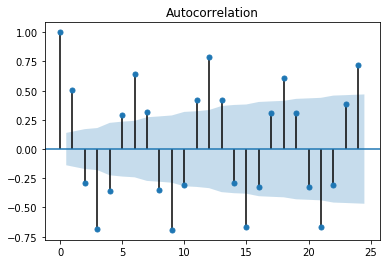

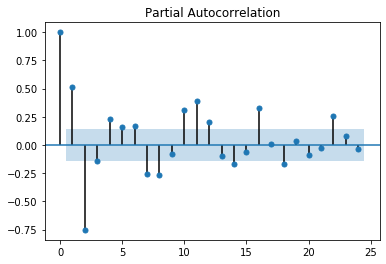

In [4]:
sm.graphics.tsa.plot_acf(df_m['PJME_MW'].values, lags=12*2)
plt.show()

sm.graphics.tsa.plot_pacf(df_m['PJME_MW'].values, lags=12*2)
plt.show()

По оценке автокорреляции можно увидить явную сезонность. Имеем сильную зависимость с лагом в 12 месяцев, а также менее сильную, но все еще существенную с лагом в 6 месяцев.

### Построим SARIMAX

In [5]:
# Определим p, d и q 
q = 2
p = 1
d = 2
pdq = [p, d, q]

# определим комбинации сезонных параметров p, q и q, 
# так как мы работаем с месячным представлением данных наша сезонность будет 12
qs = 1
ps = 0
ds = 0
seasonal_pdq = [ps, ds, qs ,12] 

In [6]:
mod = sm.tsa.statespace.SARIMAX(df_m['PJME_MW'].values[:-12],order=pdq,
                                seasonal_order=seasonal_pdq ,
                                enforce_stationarity= False ,
                                enforce_invertibility=False)
results = mod.fit()
print('SARIMAX{}x{} - AIC:{}'.format(pdq, seasonal_pdq, results.aic))

SARIMAX[1, 2, 2]x[0, 0, 1, 12] - AIC:3204.054461059814


In [7]:
print(results.summary().tables[0],results.summary().tables[1])

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  188
Model:             SARIMAX(1, 2, 2)x(0, 0, [1], 12)   Log Likelihood               -1597.027
Date:                              Wed, 15 Apr 2020   AIC                           3204.054
Time:                                      23:43:40   BIC                           3219.763
Sample:                                           0   HQIC                          3210.428
                                              - 188                                         
Covariance Type:                                opg                                         
============================================================================================ ==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
-----

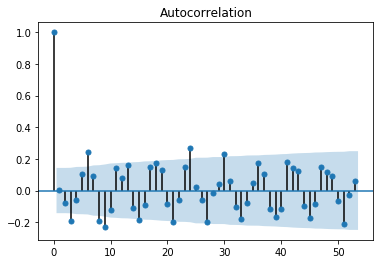

In [8]:
sm.graphics.tsa.plot_acf(results.resid, lags=53)
plt.show()

__Анализ результатов по results в сравнении с недельной моделью:__
 - так как на месячном ресемплинге данных становится меньше, AIC и BIC тоже становятся меньше
 - в отличии от модели на недельных данных коэффициент __ar.L1__ вырос, коэффициенты сглаживания также остались важными
 - остатки ряда с точки зрения автокорреляции имеют большую корреляцию, чем на недельных данных, но зависимость по прежнему не сильная

__Оценим близости распределений остатков модели к нормальному закону__

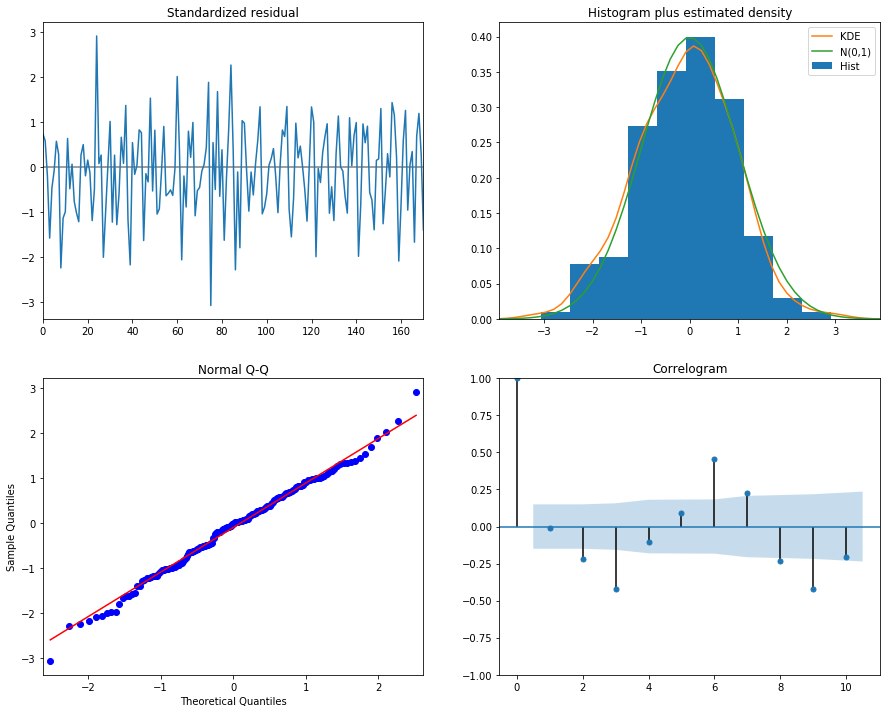

In [9]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

Как видим распределение очень близко к нормальному, __ближе чем на недельных данных__. Однако стоит заметить, что на грфике автокорреляции наблюдается большая корреляция, чем на недельных данных.

Тем не менее, данная модель подходит для анализа и прогнозирования данных временных рядов.

### Подбор параметров

In [10]:
import itertools

p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))

p = [0] 
d = [0,1]
q = range(0, 3)

seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [11]:
warnings.filterwarnings("ignore")
best_aic = 99999999
best_pqd = [1,1,1]
best_seasonal_pdq = [1,1,1]
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df_m['PJME_MW'],order=param,
                                    seasonal_order=param_seasonal ,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)

            results_ = mod.fit()
            print('ARIMA{}x{}3 - AIC:{}'.format(param, param_seasonal, results_.aic))
            # записываем лучший aic
            if results_.aic < best_aic:
                best_aic = results_.aic
                best_pqd = param
                best_seasonal_pdq = param_seasonal
        except:
            continue
print('Лучший pqd: {}, seasonal_pqd: {} AIC: {}'.format(best_pqd, best_seasonal_pdq,  best_aic))

ARIMA(0, 0, 0)x(0, 0, 0, 12)3 - AIC:4699.195491264933
ARIMA(0, 0, 0)x(0, 0, 1, 12)3 - AIC:4290.040464872466
ARIMA(0, 0, 0)x(0, 0, 2, 12)3 - AIC:3987.176443556349
ARIMA(0, 0, 0)x(0, 1, 0, 12)3 - AIC:3372.7214168798077
ARIMA(0, 0, 0)x(0, 1, 1, 12)3 - AIC:3143.066928715247
ARIMA(0, 0, 0)x(0, 1, 2, 12)3 - AIC:2904.7464905692987
ARIMA(0, 0, 1)x(0, 0, 0, 12)3 - AIC:4534.039921070028
ARIMA(0, 0, 1)x(0, 0, 1, 12)3 - AIC:4225.338467513278
ARIMA(0, 0, 1)x(0, 0, 2, 12)3 - AIC:3947.2810695606645
ARIMA(0, 0, 1)x(0, 1, 0, 12)3 - AIC:3330.6866857595214
ARIMA(0, 0, 1)x(0, 1, 1, 12)3 - AIC:3103.470814032782
ARIMA(0, 0, 1)x(0, 1, 2, 12)3 - AIC:2869.8038521474055
ARIMA(0, 0, 2)x(0, 0, 0, 12)3 - AIC:4478.921088805264
ARIMA(0, 0, 2)x(0, 0, 1, 12)3 - AIC:3776.1995531148013
ARIMA(0, 0, 2)x(0, 0, 2, 12)3 - AIC:3924.804408772498
ARIMA(0, 0, 2)x(0, 1, 0, 12)3 - AIC:3315.6786725106313
ARIMA(0, 0, 2)x(0, 1, 1, 12)3 - AIC:3087.848067887174
ARIMA(0, 0, 2)x(0, 1, 2, 12)3 - AIC:2854.2202541760753
ARIMA(0, 1, 0)x(0, 0

ARIMA(2, 2, 1)x(0, 0, 1, 12)3 - AIC:3432.2931779872933
ARIMA(2, 2, 1)x(0, 0, 2, 12)3 - AIC:3202.5266263519793
ARIMA(2, 2, 1)x(0, 1, 0, 12)3 - AIC:3379.477358435729
ARIMA(2, 2, 1)x(0, 1, 1, 12)3 - AIC:3095.2594470087565
ARIMA(2, 2, 1)x(0, 1, 2, 12)3 - AIC:2850.1160831968627
ARIMA(2, 2, 2)x(0, 0, 0, 12)3 - AIC:3558.5022339960365
ARIMA(2, 2, 2)x(0, 0, 1, 12)3 - AIC:3335.3208716768577
ARIMA(2, 2, 2)x(0, 0, 2, 12)3 - AIC:3121.4082258955195
ARIMA(2, 2, 2)x(0, 1, 0, 12)3 - AIC:3359.0733970968477
ARIMA(2, 2, 2)x(0, 1, 1, 12)3 - AIC:3067.242762746936
ARIMA(2, 2, 2)x(0, 1, 2, 12)3 - AIC:2855.531361026276
Лучший pqd: (1, 1, 2), seasonal_pqd: (0, 1, 2, 12) AIC: 2827.5997607349796


Лучшие результаты на месячных данных параметры модели __SARIMAX(1, 1, 2)x(0, 1, 2, 12) - AIC:2827.5997__ (для p,q,d,ps,ds,qs из диапазона [0,1,2]).

### Построение модели с лучшими параметрами

In [12]:
mod = sm.tsa.statespace.SARIMAX(df_m['PJME_MW'].values[:-12],order=best_pqd,
                                seasonal_order=best_seasonal_pdq,
                                enforce_stationarity= False,
                                enforce_invertibility=False)
results_opt = mod.fit()
print('AIC:{}'.format(results.aic))

AIC:3204.054461059814


Сравним первую модель и модель с лучшими параметрами

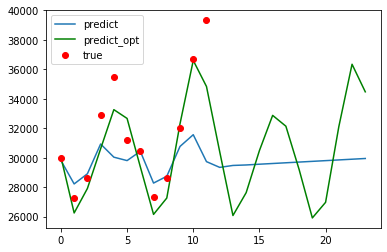

In [13]:
pred_dynamic = results.forecast(24)
pred_dynamic_opt = results_opt.forecast(24)

plt.plot(pred_dynamic, label='predict' )
plt.plot(pred_dynamic_opt,'g', label='predict_opt' )

#Отобразим истинный значения 
plt.plot(df_m['PJME_MW'].values[-12:],'or',label='true')
plt.legend()
plt.show()

По графикам очевидо, новая модель отрабатывает намного лучше.

Также посмотрим на графики распределения новой модели:

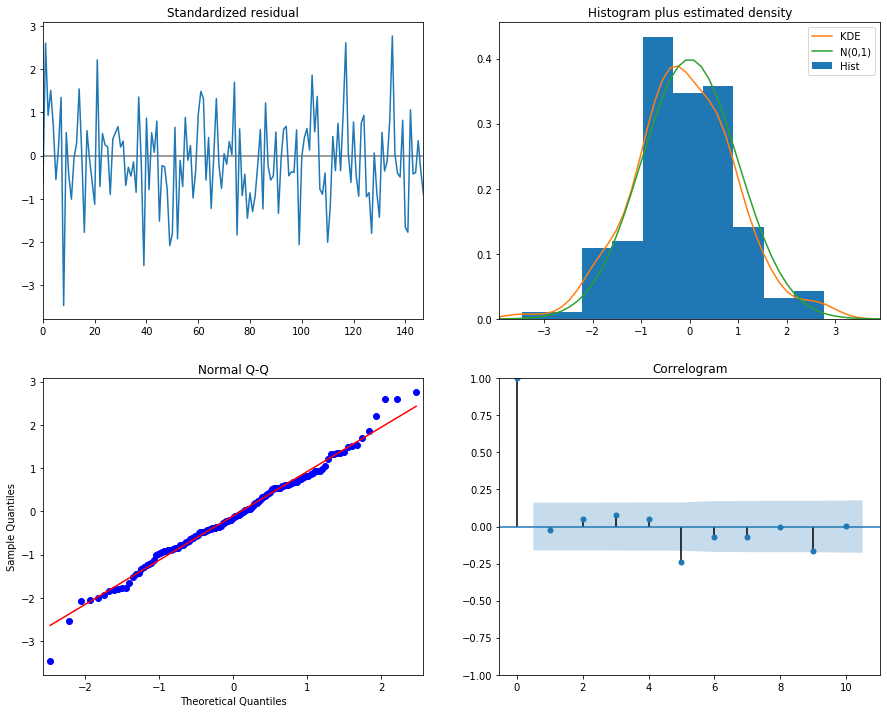

In [14]:
results_opt.plot_diagnostics(figsize=(15, 12))
plt.show()

Здесь нет сильных изменений по сравнению с предыдущей моделью не считая график автокорреляции, теперь он выглядит явно лучше.